# Person - exploratory data analysis

This Notebook contains data analysis and deals with extreme outliers in the dataset.

In [33]:
# import ConfigImports Notebook to import and configure libs
%run ../ConfigImports.ipynb

In [34]:
df = pd.read_csv('../Datasets/UniqueObjectDetections__person__2019-09-09_2020-03-02.csv')
print(df.shape)
df.head(2)

(4779, 26)


,img_idx,label,confidence,x1,y1,x2,y2,date,time,filename,img_n_boxes,time_ms,date_time,week_day,is_weekend,month,hour,min,dummy_var,time_diff,sec_diff,x_center,y_center,prev_x_center,prev_y_center,euc_distance
0,73740,person,0.450496,459,24,478,38,2019-09-09,07.03.03,07.03.03.965_4d9909b4_person-car-car-car.jpg,2,965,2019-09-09 07:03:03.965,Monday,False,9,7,3,1,0 days 00:42:40.471000000,2560.471,468.5,31.0,490.0,310.0,279.827179
1,73135,person,0.658724,286,238,381,340,2019-09-09,07.29.50,07.29.50.440_4e0ee29d_person-car-car.jpg,1,440,2019-09-09 07:29:50.440,Monday,False,9,7,29,1,0 days 00:26:46.475000000,1606.475,333.5,289.0,468.5,31.0,291.185508


### Pre-process data

This analysis will be performed at the daily / hourly level.

I have tried several other approaches (from 15-minute to 3-hour time intervals), but 15 minutes is too noisy and 3 hours reduces the dataset size to very small. Seems like hourly analysis (and later forecasting) is a good trade off.

To roll up the data to daily / hourly level we can use Pandas. This is straight forward.

The only issue I have identified with this approach is that it will only include date / hour combinations with observations. But in order to analyse data, gaps without any observations need to be filled with 0's. This is done in the code snippet below.

In [35]:
# make sure Pandas understands date time fields
df['date_time'] = pd.to_datetime(df['date_time'])
df['date'] = pd.to_datetime(df['date'])

In [36]:
# count number of Person detections for each day and hour
date_hour_counts = df.groupby(['date', 'hour'], as_index=False)['date_time'].count()
date_hour_counts.columns = ['date', 'hour', 'obs_count']

In [37]:
# now fill-in missing hours with 0-count observations
to_fill = []
for dt in pd.date_range(date_hour_counts['date'].min(),
                        date_hour_counts['date'].max(), freq='H'):
    dt, hr = str(dt.date()), dt.hour
    idx = (date_hour_counts['date'] == dt) & (date_hour_counts['hour'] == hr)
    if date_hour_counts[idx].shape[0] == 0:
        to_fill.append({'date': dt, 'hour': hr, 'obs_count': 0})

# now we can stitch the original dataset with "to_fill" into a single dataframe
date_hour_counts_filled = pd.concat([date_hour_counts, pd.DataFrame(to_fill)])
date_hour_counts_filled['date'] = pd.to_datetime(date_hour_counts_filled['date'])
date_hour_counts_filled = date_hour_counts_filled.sort_values(['date', 'hour'])

In [38]:
# remove any entries where we know that there was an error in measurements
idx = date_hour_counts_filled['date'].isin(['2020-01-13', '2020-01-14', '2020-02-28'])
date_hour_counts_filled = date_hour_counts_filled.loc[~idx]

### Distribution

To see a distribution of counts, we can plot a histogram. To make it more interesting for analysis, instead of counts we can actually use the probability density, which tells us the probability of obtaining the distinct counts.

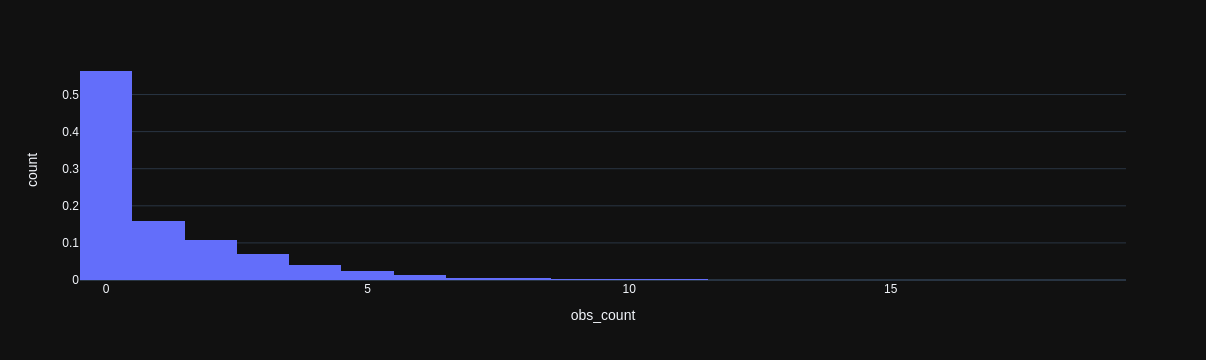

In [39]:
px.histogram(date_hour_counts_filled, x="obs_count", height=300, nbins=20, histnorm='probability density')

This data is heavily skewed towards 0's, but this is expected as during the night or when it's dark, the number of objects will be zero and we are not using a night vision camera.

### Analyse outliers

What is an outlier in this scenario?

It's a scenario, where within 1 hour time interval, there was much lower or much higher number of observations versus the expected value.

Snippet below generates useful statistics for each hour in the dataset.

In [40]:
# group by hour and generate stats at that level
grouped = date_hour_counts_filled.groupby('hour')['obs_count']
stats = grouped.agg(['min', 'max', 'mean'])

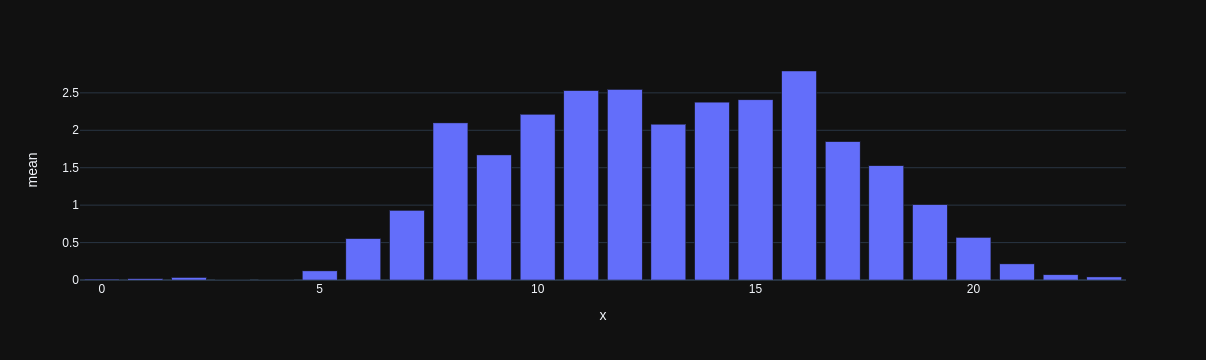

In [41]:
# verify means for each hour
px.bar(stats, y='mean', x=stats.index, height=300)

It's clear that the distribution of detections by hour is quite Gaussian like, as expected. It is definitely skewed due to outliers, but at this point we are only interested in the overall data distribution.

Another approach would be to draw a plot the median metric, but it looks less interesting due to the low range of values.

Now we can draw a box plot for each hour can be drawn to analyse outliers. It actually uses a median value to calculate statistics.

Why box plot?

As described at [www.w3resource.com](https://www.w3resource.com/pandas/dataframe/dataframe-boxplot.php):
A box plot is a method for graphically depicting groups of numerical data through their quartiles. The box extends from the Q1 to Q3 quartile values of the data, with a line at the median (Q2). The whiskers extend from the edges of box to show the range of the data. The position of the whiskers is set by default to $1.5 * IQR (IQR = Q3 - Q1)$ from the edges of the box. Outlier points are those past the end of the whiskers.

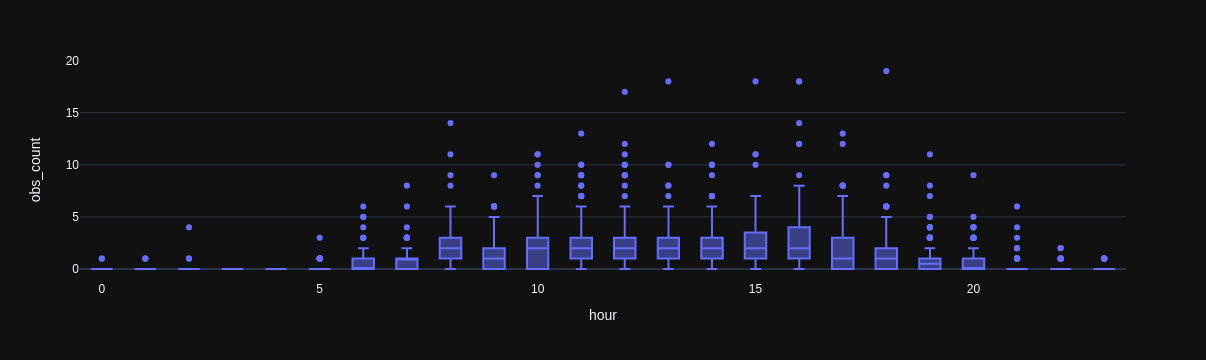

In [42]:
px.box(date_hour_counts_filled, x="hour", y="obs_count", height=300)

Boxplots show that there are a lot of significant outliers in the dataset. These should be looked into even deeper to see if there are any gaps in the system.

For now the heaviest outliers can be removed using the IQR method. It is a two step process:
- analytically detect the outliers
- remove these from the dataset

The base for the function below can be found in the online [Engineering Statistics Handbook](https://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm)

In [43]:
def rm_outliers(df_in, col_name, iqr_multiplier=1.5, debug=False):
    """Calculate outliers based on the interquartile range (IQR)"""
    q1, q3 = df_in[col_name].quantile(0.25), df_in[col_name].quantile(0.75)  # first and third quartiles
    iqr = q3 - q1  # interquartile range
    fence_low, fence_high = q1 - iqr_multiplier * iqr, q3 + iqr_multiplier * iqr  # lower and upper bounds
    if debug:
        print('q1', q1)
        print('q3', q3)
        print('iqr', iqr)
        print('fence_low', fence_low)
        print('fence_high', fence_high)
    idx = (df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)
    return df_in.loc[idx], iqr, fence_low, fence_high

#### Note:

While boxplots use the multiplier $IQR=1.5$, it uses lower and upper fences to find the so-called **mild outliers**.

The approach I have taken below is a little bit more forgiving as it uses a multiplier of $IQR=3$, which is known to identify only the **extreme outliers** [(www.itl.nist.gov)](https://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm)

In [44]:
# find upper and lower fences for each hour
fences = []
for name, group in grouped:
    g = pd.DataFrame(group)
    g_outliers, iqr, fence_low, fence_high = rm_outliers(g, 'obs_count', iqr_multiplier=3)
    if iqr != 0:
        fences.append({'hour': name, 'low': fence_low, 'high': fence_high})
        
# now remove all entries, which breach the bound for each hour
dt_hr_no_outliers = date_hour_counts_filled.copy()
n_removed = 0
for fence in fences:
    hr, min_val, max_val = fence['hour'], fence['low'], fence['high']
    idx = (dt_hr_no_outliers['hour'] == hr) & ((dt_hr_no_outliers['obs_count'] \
                                           <= min_val) | (dt_hr_no_outliers['obs_count'] >= max_val))
    n_removed += dt_hr_no_outliers.loc[idx].shape[0]
    dt_hr_no_outliers = dt_hr_no_outliers.loc[~idx]
print(f'{n_removed} extreme outliers removed')

62 extreme outliers removed


As observed in the output above, **62 extreme outliers** have been removed from the dataset (while $IQR=1.5$ identified 172 data points as mild outliers).

The intuition here is that we should always aim to remove as few data points as possible, unless the results suggest otherwise.

As plotted below, the approach indeed removed majority of the most significant outliers from the dataset. While there are certainly some outliers kept, it is not a problem as in reality we do need some noise in the dataset.

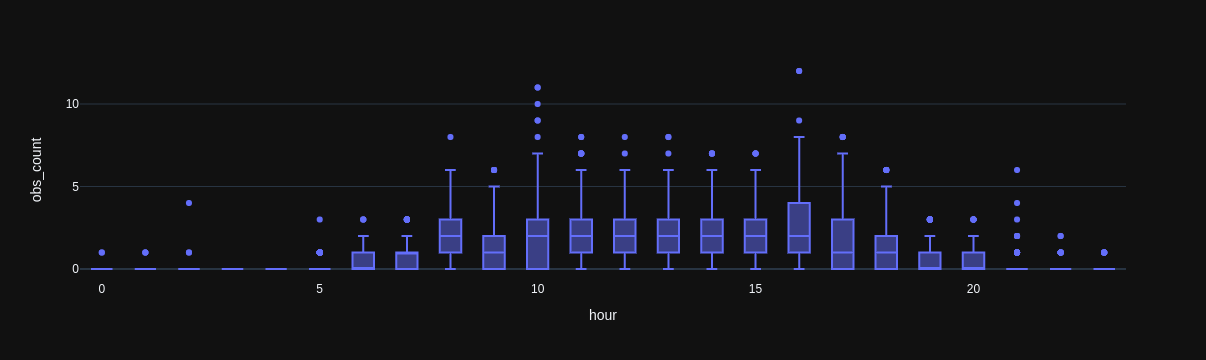

In [45]:
px.box(dt_hr_no_outliers, x="hour", y="obs_count", height=300)

In [31]:
# save data to csv, so we can conduct feature engineering in another Notebook
dt_hr_no_outliers.to_csv('../Datasets/Person_no_outliers__2019-09-09_2020-03-02.csv',
                         index=False)